# Importing Libraries

In [ ]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sb

# Modelling and Analysis
from scipy.stats import iqr
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, GRU
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Miscellaneous
from itertools import product
import warnings
from collections import Counter, OrderedDict

# West Africa Staple Crop Analysis (Wheat, Rice, Maize)
Units:
* **Crop Yield: x100 g/ha**
* **Land Surface Temperature change: °c**
* **Annual Precipitation: mm**

In [ ]:
def frame_cleaner(frame):
  '''This function checks if any duplicates or missing values exist
      in a given dataframe.

  parameters:
  frame (pandas.DataFrame): name of dataframe to check

  return:
  string showing number of missing or duplicate values'''

  # Search for duplicate values
  duplicated_df = frame[frame.duplicated()]
  # Perform column-wise search for missing values
  missing = frame.isna().sum().tolist()

  print(f'Missing Values: {missing.count(1)}, Duplicate Values: {len(duplicated_df)}')

## Load Yield and LST Data for West Africa (Obtained from FAO)

In [ ]:
# Define path for crop data
yield_path = r'/content/drive/MyDrive/Dissertation/FAOSTAT_data_en_7-1-2024 (West Africa rgCrops).csv'

# Define path for temperature change data
temp_path = r'/content/drive/MyDrive/Dissertation/FAOSTAT_data_en_7-1-2024 (West Africa rgTemp).csv'

In [ ]:
# Load crop data
yield_data = pd.read_csv(yield_path, usecols=['Item', 'Year', 'Value'])

# Load temperature change data
lst_data = pd.read_csv(temp_path, usecols= ['Year', 'Value'])

In [ ]:
# Check yield data consistency
frame_cleaner(yield_data)

# Check LST data consistency
frame_cleaner(lst_data)

Missing Values: 0, Duplicate Values: 0
Missing Values: 0, Duplicate Values: 0


In [ ]:
# View subset of crop Yield data
yield_data.groupby('Item').sample(2, random_state=43)

,Item,Year,Value
52,Maize (corn),2013,15247
45,Maize (corn),2006,16568
115,Rice,2014,20565
114,Rice,2013,18905
166,Wheat,2003,11163
128,Wheat,1965,16332


In [ ]:
# View subset of LST data
lst_data.head()

,Year,Value
0,1961,-0.289
1,1962,-0.130
2,1963,0.201
3,1964,-0.189
4,1965,-0.227


## Load and Average Precipitation data of West African Countries (Obtained from CCKP)

In [ ]:
# define data path
rain_data_path = r'/content/drive/MyDrive/Dissertation/cru-x0.5_timeseries_pr_timeseries_annual_1901-2022_mean_historical_cru_ts4.07_mean.xlsx'

# load data
rain_data = pd.read_excel(rain_data_path, index_col='name')

# drop redundant column
rain_data.drop(columns='code', inplace=True)

# transpose data
rain_data = rain_data.T

# set index name
rain_data.reset_index(inplace=True)
rain_data.rename(columns={'index':'Year'}, inplace=True)

# extract year from data
rain_data['Year'] = pd.to_datetime(rain_data['Year']).dt.year

# select 1961-2022
rain_data = rain_data[rain_data['Year'].isin([year for year in range(1961, 2023)])].sort_values(by='Year', ignore_index=True)

# reindex
rain_data.set_index('Year', inplace=True)

In [ ]:
# subset of original dataset
rain_data.head()

name,Benin,Burkina Faso,Côte d'Ivoire,Cabo Verde,Ghana,Guinea,Guinea-Bissau,Liberia,Mali,Mauritania,Niger,Nigeria,Senegal,Sierra Leone,Togo
Year,,,,,,,,,,,,,,,
1961,981.25,859.84,1219.68,268.44,1115.89,1920.63,1941.97,2417.00,359.87,118.09,234.01,1137.82,877.19,2938.19,1105.46
1962,1304.25,952.72,1577.54,251.50,1458.05,2142.98,1884.93,2817.55,371.79,131.43,206.98,1356.45,783.13,3049.17,1489.16
1963,1378.38,952.25,1686.06,260.03,1679.38,1954.57,1817.95,3134.51,350.74,120.49,184.21,1354.66,823.66,2931.90,1673.18
1964,1083.33,982.30,1405.31,235.23,1214.93,2017.51,1926.22,2479.98,396.92,135.57,247.13,1241.07,900.32,2657.21,1213.27
1965,1046.10,893.55,1317.64,284.34,1298.15,1924.40,2123.74,2589.09,373.75,160.72,200.57,1201.45,901.79,2699.82,1242.76


In [ ]:
# Check precipitation data consistency
frame_cleaner(rain_data)

Missing Values: 0, Duplicate Values: 0


In [ ]:
# calculate the average preciptation for West Africa
avg_rain_data = np.round(rain_data.mean(axis=1).reset_index(), 3)

# rename column
avg_rain_data.rename(columns={0:'average_precipitation (mm)'}, inplace=True)

In [ ]:
# View subset of averaged precipitation
rain_data.tail()

name,Benin,Burkina Faso,Côte d'Ivoire,Cabo Verde,Ghana,Guinea,Guinea-Bissau,Liberia,Mali,Mauritania,Niger,Nigeria,Senegal,Sierra Leone,Togo
Year,,,,,,,,,,,,,,,
2018,1108.39,927.99,1456.21,205.07,1315.19,1775.13,1516.17,2452.65,353.30,111.69,211.72,1233.04,686.70,2656.85,1294.23
2019,1181.79,919.41,1423.61,237.80,1450.15,1798.73,1618.19,2429.98,350.29,107.66,199.56,1296.78,710.87,2478.26,1478.49
2020,1113.37,948.45,1323.15,205.07,1232.15,1765.58,1669.24,2430.54,369.22,128.06,250.60,1254.97,779.85,2604.46,1180.35
2021,1016.67,840.51,1356.73,205.07,1262.45,1801.77,1587.53,2421.61,321.76,113.04,158.12,1114.97,731.46,2788.62,1220.43
2022,1082.93,940.98,1396.65,205.07,1230.61,2012.33,2168.64,2423.01,386.32,137.61,206.56,1228.76,936.40,2684.28,1208.14


## Merging all datasets to create a comprehensive dataset

In [ ]:
# data LST and Yield Data
merged_data = pd.merge(yield_data, lst_data, on=['Year'])

# Merge LST+Yield and Average Precipitation
merged_data = merged_data.merge(avg_rain_data, right_on='Year', left_on='Year')

# rename columns
merged_data.rename(columns={'Item':'crop', 'Value_x':'crop_yield', 'Value_y':'temp_change'}, inplace=True)

In [ ]:
# View subset of merged dataset
merged_data.groupby('crop').sample(2, random_state=43)

,crop,Year,crop_yield,temp_change,average_precipitation (mm)
156,Maize (corn),2013,15247,1.068,1094.031
135,Maize (corn),2006,16568,1.217,1165.186
160,Rice,2014,20565,1.060,1138.763
157,Rice,2013,18905,1.068,1094.031
128,Wheat,2003,11163,1.063,1198.643
14,Wheat,1965,16332,-0.227,1217.191


## Separate datasets for each crop (rice, maize and wheat)

In [ ]:
# Create Rice Dataset
rice_data = merged_data[merged_data['crop'] == 'Rice'].reset_index(drop=True)

# Create Maize Dataset
maize_data = merged_data[merged_data['crop'] == 'Maize (corn)'].reset_index(drop=True)

# Create Wheat Dataset
wheat_data = merged_data[merged_data['crop'] == 'Wheat'].reset_index(drop=True)

In [ ]:
# subset of rice data
rice_data.head(3)

,crop,Year,crop_yield,temp_change,average_precipitation (mm)
0,Rice,1961,9342,-0.289,1166.355
1,Rice,1962,10229,-0.130,1318.509
2,Rice,1963,10793,0.201,1353.465


In [ ]:
# subset of maize data
maize_data.head(3)

,crop,Year,crop_yield,temp_change,average_precipitation (mm)
0,Maize (corn),1961,7414,-0.289,1166.355
1,Maize (corn),1962,7681,-0.130,1318.509
2,Maize (corn),1963,8234,0.201,1353.465


In [ ]:
# subset of wheat data
wheat_data.head(3)

,crop,Year,crop_yield,temp_change,average_precipitation (mm)
0,Wheat,1961,16334,-0.289,1166.355
1,Wheat,1962,16082,-0.130,1318.509
2,Wheat,1963,16071,0.201,1353.465


# Exploratory Data Analysis

## Auxilliary Functions

In [ ]:
def create_summary_table(crop_data):
  """Creates a summary table with average, minimum and maximum yields,
  as well as correlations.

  parameters:
    crop_data (pandas.DataFrame): Dataset to compute.

  Returns:
    summary_table (pandas.DataFrame): Dataframe of aggregate values
  """
  # Compute data aggregates
  summary_table = round(crop_data.groupby('crop').agg(
      max_Yield = ('crop_yield', 'max'), # compute maximum crop yield
      min_Yield = ('crop_yield', 'min'), # compute minimum crop yield
      average_Yield=('crop_yield', 'mean'), # compute mean crop yield
      yield_LST_correlation=('crop_yield', lambda x: x.corr(crop_data['temp_change'])), # compute crop yield correlation with LST
      yield_precipitation_correlation=('crop_yield', lambda x: x.corr(crop_data['average_precipitation (mm)'])) # compute crop yield correlation with precipitation
  ).reset_index(),2)

  return summary_table

## Exploring Yield Trends

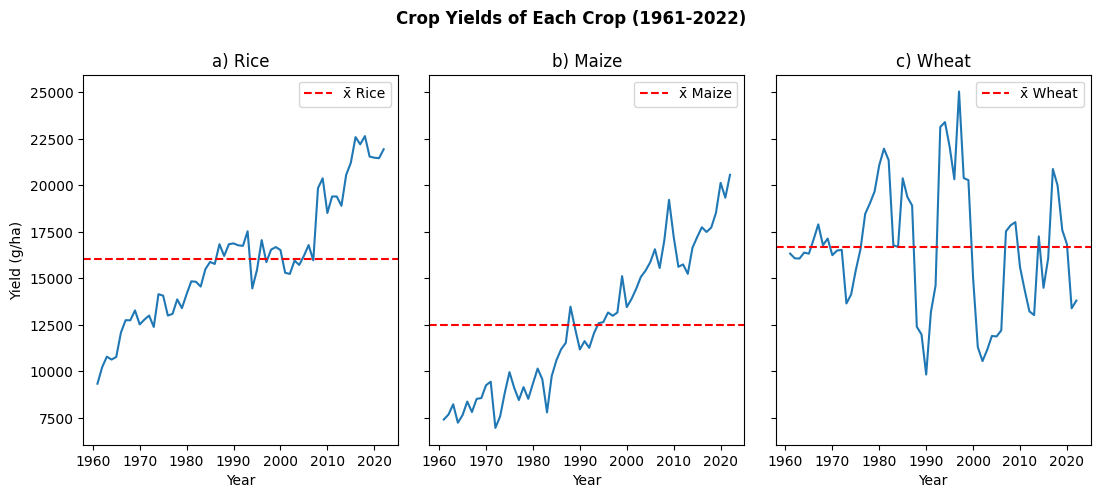

In [ ]:
fig, ax = plt.subplots(figsize=(13, 5), nrows=1, ncols=3, sharey=True)

# Plot Rice Yield trends
sb.lineplot(data=rice_data, y='crop_yield', x='Year', ax=ax[0])
ax[0].axhline(linestyle ='--', color='r', y=np.mean(rice_data.crop_yield), label='x̄ Rice') # add line to show mean
ax[0].set_title('a) Rice') # set subplot title
ax[0].legend()

# Plot Maize Yield Trends
sb.lineplot(data=maize_data, y='crop_yield', x='Year', ax=ax[1])
ax[1].axhline(linestyle ='--', color='r', y=np.mean(maize_data.crop_yield), label='x̄ Maize') # add line to show mean yield
ax[1].set_title('b) Maize') # set subplot title
ax[1].legend()

# Plot Wheat Yield Trends
sb.lineplot(data=wheat_data, y='crop_yield', x='Year', ax=ax[2])
ax[2].axhline(linestyle ='--', color='r', y=np.mean(wheat_data.crop_yield), label='x̄ Wheat') # add line to show mean yield
ax[2].set_title('c) Wheat') # set subplot title
ax[2].legend()

# Set plot title and labels
plt.setp(ax, ylabel= 'Yield (g/ha)')
plt.suptitle('Crop Yields of Each Crop (1961-2022)', fontweight='bold')


# Adjust subplot placements
plt.subplots_adjust(wspace=0.1, top=0.85)
#plt.tight_layout()

## Exploring Climate Trends

Text(0.5, 0.98, 'Climate Trends (1961-2022)')

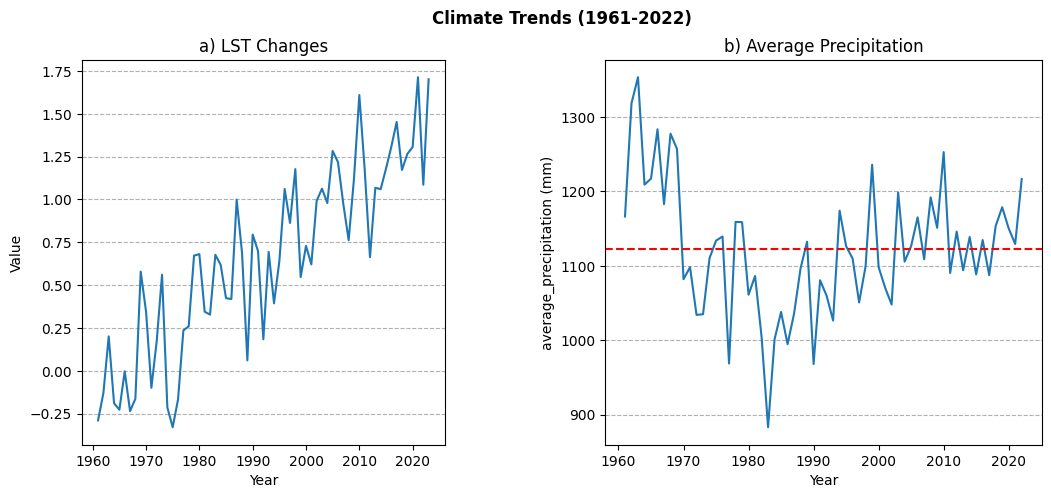

In [ ]:
# Set subplot dimensions
fig, ax = plt.subplots(figsize=(12, 5), nrows=1, ncols=2, sharey=False, width_ratios=[5,6])

# Plot LST trends
sb.lineplot(data=lst_data, y='Value', x='Year', ax=ax[0]).grid(linestyle='--', axis='y')
ax[0].set_title('a) LST Changes') # set plot title

# Plot precipitation trends
sb.lineplot(data=avg_rain_data, y='average_precipitation (mm)', x='Year', ax=ax[1]).grid(linestyle='--', axis='y')
ax[1].axhline(linestyle ='--', color='r', y=np.mean(avg_rain_data['average_precipitation (mm)'])) # add line to show mean
ax[1].set_title('b) Average Precipitation') # set plot title

# Adjust subplot placements
plt.subplots_adjust(left=0.1, wspace=0.4)
plt.suptitle('Climate Trends (1961-2022)', fontweight='bold')

## Summary Statistics for each crop

In [ ]:
# Compute summary statistics for each crop
crop_summary = create_summary_table(merged_data)
crop_summary

,crop,max_Yield,min_Yield,average_Yield,yield_LST_correlation,yield_precipitation_correlation
0,Maize (corn),20574,6964,12520.63,0.83,0.08
1,Rice,22654,9342,16038.39,0.80,-0.12
2,Wheat,25049,9833,16673.66,-0.09,-0.05


# **Modeling**
In this section, two sets of models are built.

1.   Forecasting Model (ARIMA)
2.   Prediciting Models

# Forecasting

## Auxilliary Functions
This section defines helper functions used in this section and throughout the notebook

In [ ]:
def find_arima_params(train, test, temp=False):
  """
  This function performs a grid search to find the optimal ARIMA model
  Uses RMSE as evaluation metric.

  Parameters:
  train (pandas.Series): train dataset.
  test (pandas.Series): test dataset.
  temp (bool): specify type for returned values

  Returns:
      A tuple containing:
          - rmse_scores: A dictionary containing all models and rmse
          - best_param: The ARIMA model with the lowest RMSE.
          - min_rmse: The best score achieved on the data.
          - aic_scores: A dictionary containing all models and AIC scores
          - rev_scores: A dictionary containing all models and rmse
          where dictionary overwrite exists
  """

  p_vals = [i for i in range(10)] # Possible p (AR -Autoregressive) values
  d_vals = [0,1,2] # Possible d values (The differencing order)
  q_vals = [i for i in range(10)] # Possible q values (The MA (Moving Average)

  all_rmse = [] # List to store all RMSE scores
  all_aic = [] # List to store all AIC scores

  possible_values = product(p_vals,d_vals,q_vals) # generate a list of possible models
  pv = [] # a list to store completed combinations

  for each_combination in possible_values: # loop through possible models
    pv.append(each_combination) # append current model to list
    warnings.filterwarnings("ignore")

    p = each_combination[0] # select index 0 as p value
    d = each_combination[1] # select index 1 as d value
    q = each_combination[2] # select index 2 as q value

    # Build ARIMA model with each model
    model = ARIMA(train, order=(p, d, q))
    model_fit = model.fit() # fit model

    # Make predictions with model
    forecast = model_fit.forecast(len(test)).to_list()
    # if temp, return values as floats
    if temp:
      forecast_data = model_fit.forecast(len(test)).to_list()
    # else, return values as integers
    else:
      forecast_data = [int(val) for val in forecast]

    # compute mean squared error for model prediction
    mse_ = mse(y_true=test.to_list(), y_pred=forecast_data)
    # compute root mean squared error for model prediction
    rmse = np.round(np.sqrt(mse_),3)
    aic = model_fit.aic

    all_rmse.append(rmse) # append rmse score to general list
    all_aic.append(aic) # append AIC score to general list

  rev_scores = dict(zip(pv, all_rmse)) # a reversed list to handle key overwirting
  rmse_scores = dict(zip(all_rmse,pv)) # create dictionary of models and rmse
  aic_scores = dict(zip(all_aic,pv)) # create dictionary of models and AIC
  min_rmse = min(rmse_scores.keys()) # find lowest rmse
  best_param = rmse_scores[min_rmse] # find model with lowest rmse

  # Ensure retuned dictionary length is 300 (total combinations)
  try:
    assert len(rmse_scores) == 300
  except AssertionError:
    print('Dictionary Overwrite exists, use index 4')

  return rmse_scores, best_param, min_rmse, aic_scores, rev_scores

In [ ]:
def forecast_plot(train, test, forecast, crop, _ax=0, targ='crop_yield'):
  """
  Plots the original train and test datasets along with the predicted values.

  Parameters:
  train (pandas.Series): Original train dataset.
  test (pandas.Series): Original test dataset.
  forecast (pandas.Series): Predicted data.

  Returns:
  None: The function will display a plot.
  """

  # Create dataframe for test data
  vento = pd.DataFrame(test).set_index('Year')

  # Predicted data
  vento['predicted'] = forecast

  # Original data
  original = train[['Year',targ]].set_index('Year')

  # Original Test data
  original_other = test[['Year',targ]].set_index('Year')

  # Set plot size
  plt.figure(figsize=(7,5))

  # Plot the first 10 years of original data
  #plt.plot(original, 'b-', label = 'Original Data')
  sb.lineplot(data = original, x='Year', y=targ, label='Train', color='b', ax=ax[_ax])

  # Plot the original test data
  #plt.plot(original_other, 'g-', label='Original Test Data')
  sb.lineplot(data = original_other, x='Year', y=targ, label='Test', color='g', ax=ax[_ax])

  # Plot the predicted values
  #plt.plot(vento['predicted'], 'r--', label='Predicted')
  sb.lineplot(data = vento, x='Year', y='predicted', label='Predicted', color='r', ax=ax[_ax], linestyle='--')

In [ ]:
def model_data(data):
  """Splits a pandas DataFrame into training (1961-2012) and test (2012, 2023) sets.

  Parameters:
    data (pandas.DataFrame): The pandas DataFrame containing the data to be split.

  Returns:
    A tuple containing the training and test DataFrames.
  """
  # train data selection
  train_data = data[data['Year'].isin([year for year in range(1961, 2012)])].sort_values(by='Year', ignore_index=True)
  # test data selection
  test_data = data[data['Year'].isin([year for year in range(2012, 2023)])].sort_values(by='Year', ignore_index=True)

  return train_data, test_data

In [ ]:
def handle_overwrite(scores):
  """Refilters model Selection using RMSE and AIC scores.

  Args:
    scores: A dictionary containing ARIMA model scores.

  Returns:
    List of possible model configurations to examine further.
  """

  v = dict(Counter(scores[4].values())) # count all rmse values
  sorted_rmse = sorted(v.items(), key=lambda x: x[0]) # sort all counted  values in ascending order

  common_low = sorted_rmse[0][0] # obtain common lowest rmse
  same_rmse_aic = [] # list to store aic of all models with same low rmse
  for mod, rmse in scores[4].items(): # loop through each model and their rmse
    if rmse == common_low: # if the model rmse corresponds to lowest,
      same_rmse_aic.append(mod) # append model parameters

  # obtain all models and AIC that match the lowest rmse
  over_temp = {x: np.round({val:key for key,val in scores[3].items()}[x],3) for x in same_rmse_aic}

  good_models = [] # list to store all configuraations to examine

  for mod, aic in over_temp.items():
    # if model aic is at most 10% more than minimum, consider
    if aic <= (0.1 * min(over_temp.values())) + min(over_temp.values()):
      good_models.append(mod)

  print('The following configurations should be examined further:') # obtain lowest rmse
  return good_models

## Rice Forecast Model

In [ ]:
# Create train and test sets for rice data
rice_train_data = model_data(data=rice_data)[0]
rice_test_data = model_data(data=rice_data)[1]

In [ ]:
# Find best Rice ARIMA model
rice_arima_scores = find_arima_params(train=rice_train_data['crop_yield'], test=rice_test_data['crop_yield'])
# avg: 4 minutes

In [ ]:
print(f'Best Rice model {rice_arima_scores[1]} has RMSE: {rice_arima_scores[2]}')

Best Rice model (5, 1, 5) has RMSE: 617.095


In [ ]:
# Fitting ARIMA model for Rice
rice_model = ARIMA(rice_train_data['crop_yield'], order=(5, 1, 5))
rice_model_fit = rice_model.fit()

In [ ]:
# Forecasting Test Data
rice_forecast = np.round(rice_model_fit.forecast(len(rice_test_data['crop_yield']))).to_list()

## Wheat Forecast Model

In [ ]:
# Create train and test sets for wheat data
wheat_train_data = model_data(data=wheat_data)[0]
wheat_test_data = model_data(data=wheat_data)[1]

In [ ]:
# Find best Rice ARIMA model
wheat_arima_scores = find_arima_params(train=wheat_train_data['crop_yield'], test=wheat_test_data['crop_yield'])
# avg: 4 minutes

Dictionary Overwrite exists, use index 4


In [ ]:
handle_overwrite(wheat_arima_scores)

The following configurations should be examined further:


[(3, 0, 0)]

In [ ]:
print(f'Wheat model {wheat_arima_scores[1]} has lowest RMSE: {wheat_arima_scores[2]}')

Wheat model (3, 0, 0) has lowest RMSE: 2154.758


In [ ]:
# Fitting ARIMA model for Wheat
wheat_model = ARIMA(wheat_train_data['crop_yield'], order=(3, 0, 0))
wheat_model_fit = wheat_model.fit()

In [ ]:
# Forecasting Test Data
wheat_forecast = np.round(wheat_model_fit.forecast(len(wheat_test_data['crop_yield']))).to_list()

## Maize Forecast Model

In [ ]:
# Create train and test sets for wheat data
maize_train_data = model_data(data=maize_data)[0]
maize_test_data = model_data(data=maize_data)[1]

In [ ]:
# Find best Rice ARIMA model
maize_arima_scores = find_arima_params(train=maize_train_data['crop_yield'], test=maize_test_data['crop_yield'])
# avg: 4 minutes

Dictionary Overwrite exists, use index 4


In [ ]:
handle_overwrite(maize_arima_scores)

The following configurations should be examined further:


[(1, 2, 5)]

In [ ]:
print(f'Best Maize model {maize_arima_scores[1]} has RMSE: {maize_arima_scores[2]}')

Best Maize model (1, 2, 5) has RMSE: 916.458


In [ ]:
# Fitting ARIMA model for Maize
maize_model = ARIMA(maize_train_data['crop_yield'], order=(1, 2, 5))
maize_model_fit = maize_model.fit()

In [ ]:
# Forecasting Test Data
maize_forecast = np.round(maize_model_fit.forecast(len(maize_test_data['crop_yield']))).to_list()

## LST Forecast Model

In [ ]:
# Create train and test sets for rice data
lst_train_data = model_data(data=lst_data)[0]
lst_test_data = model_data(data=lst_data)[1]

In [ ]:
# Find best LST ARIMA model
lst_arima_scores = find_arima_params(train=lst_train_data['Value'], test=lst_test_data['Value'])
# avg: 4 minutes

Dictionary Overwrite exists, use index 4


In [ ]:
handle_overwrite(lst_arima_scores)

The following configurations should be examined further:


[(0, 1, 3),
 (0, 2, 3),
 (0, 2, 4),
 (1, 1, 3),
 (1, 1, 5),
 (1, 2, 3),
 (2, 1, 0),
 (2, 1, 1),
 (2, 2, 2),
 (3, 1, 5)]

In [ ]:
# Fitting ARIMA model for temperature
temp_model = ARIMA(lst_train_data['Value'], order=(3, 2, 5))
temp_model_fit = temp_model.fit()

In [ ]:
# prediction
lst_forecast = temp_model_fit.forecast(len(lst_test_data['Value'])).to_list()

## Precipitation Forecast Model

In [ ]:
# Create train and test sets for rice data
rain_train_data = model_data(data=avg_rain_data)[0]
rain_test_data = model_data(data=avg_rain_data)[1]

In [ ]:
# Find best Rain Arima model
rain_arima_scores = find_arima_params(train=rain_train_data['average_precipitation (mm)'], test=rain_test_data['average_precipitation (mm)'])

In [ ]:
# Fitting ARIMA model for temperature
rain_model = ARIMA(rain_train_data['average_precipitation (mm)'], order=(1, 1, 2))
rain_model_fit = rain_model.fit()

In [ ]:
# forecast
rain_forecast = rain_model_fit.forecast(len(rain_test_data['average_precipitation (mm)'])).to_list()

## Yield ARIMA Models Performance

In [ ]:
# Create Dataframe of arima modelmetric scores on test set
arima_yield_metrics = pd.DataFrame({'Optimal Model':[rice_model.order, maize_model.order, wheat_model.order, temp_model.order, rain_model.order],
                                   'RMSE':[rice_arima_scores[2], maize_arima_scores[2], wheat_arima_scores[2], lst_arima_scores[2], rain_arima_scores[2]]},
                                    index=['Rice', 'Maize', 'Wheat', 'LST', 'Precipitaion'])

In [ ]:
# View dataframe
arima_yield_metrics

In [ ]:
# Plot Yield Forecasts
fig, ax = plt.subplots(1,3, figsize=(13,5), sharey=True)

forecast_plot(train=rice_train_data, test=rice_test_data, forecast=rice_forecast, crop='rice', _ax=0)
ax[0].set_title('a) Rice Forecasts') # set plot title

forecast_plot(train=maize_train_data, test=maize_test_data, forecast=maize_forecast, crop='maize', _ax=1)
ax[1].set_title('b) Maize Forecasts') # set plot title

forecast_plot(train=wheat_train_data, test=wheat_test_data, forecast=wheat_forecast, crop='wheat', _ax=2)
ax[2].set_title('c) Wheat Forecasts') # set plot title

# Adjust subplot placements
fig.subplots_adjust(wspace=0.1, top=0.84)
fig.suptitle('ARIMA Crop Yield Forecasts', fontweight='bold')

# Set label
plt.setp(ax, ylabel= 'Yield (g/ha)')

## Climate ARIMA Models Performance

In [ ]:
# plot climate forecasts
fig, ax = plt.subplots(1,2, figsize=(12,5), sharey=False)

forecast_plot(train=lst_train_data, test=lst_test_data, forecast=lst_forecast, crop='LST', targ='Value', _ax=0)
ax[0].set_title('a) LST Forecasts') # set plot title
ax[0].set_ylabel('Temp Change (°C)')


forecast_plot(train=rain_train_data, test=rain_test_data, forecast=rain_forecast, crop='Temp arima', targ='average_precipitation (mm)', _ax=1)
ax[1].set_title('b) Precipitation Forecasts') # set plot title

# Adjust subplot placements
fig.subplots_adjust(wspace=0.3, top=0.84)
fig.suptitle('ARIMA Climate Forecasts', fontweight='bold')

#plt.ylabel('Temp Change (°C)')

# Forecasting Values for the next 10 years (2023 - 2033)  with ARIMA

## Retraining Models using all data with train configurations

In [ ]:
# Rice
full_rice = ARIMA(rice_data['crop_yield'], order=(5, 1, 5))
full_rice_fit = full_rice.fit()

# Maize
full_maize = ARIMA(maize_data['crop_yield'], order=(1, 2, 5))
full_maize_fit = full_maize.fit()

# Wheat
full_wheat = ARIMA(wheat_data['crop_yield'], order=(3, 0, 0))
full_wheat_fit = full_wheat.fit()

# Temp
full_temp = ARIMA(lst_data['Value'], order=(3, 2, 5))
full_temp_fit = full_temp.fit()

# rain
full_rain = ARIMA(avg_rain_data['average_precipitation (mm)'], order=(1, 1, 2))
full_rain_fit = full_rain.fit()

## Forecasting

In [ ]:
 # rice predictions
next_10_rice = np.round(full_rice_fit.forecast(10)).to_list()

# maize predictions
next_10_maize = np.round(full_maize_fit.forecast(10)).to_list()

# wheat predictions
next_10_wheat = np.round(full_wheat_fit.forecast(10)).to_list()

# temp predictions
next_10_temp = np.round(full_temp_fit.forecast(10).to_list(),2)

# rain predictions
next_10_rain = np.round(full_rain_fit.forecast(10).to_list(),0)

In [ ]:
# Create DataFrame for predictions
arima_10yr_forecasts = pd.DataFrame(data={'rice':next_10_rice, 'maize':next_10_maize, 'wheat':next_10_wheat,
                                          'temp':next_10_temp, 'rain':next_10_rain}, index=[i for i in range(2023, 2033, 1)])

In [ ]:
# Display Arima Forecasts
arima_10yr_forecasts

# **Prediction Models**
In this section, incorporating land surface temperature changes,four machine learning models to predict crop yield are built. THe four models built are:

1.   Linear Regression
2.   Decision Tree
3.   Neural Network
4.   LSTM

# Model Functions

## Linear Regression

In [ ]:
def linear_regression(data, feature='temp_change', dual=False):
  """
    This function performs linear regression on the given dataset and returns evaluation metrics.

    Parameters:
    data (pandas.DataFrame): The input dataset containing features and the target variable.
    feature (str): Feature(s) to consider. (default: lst)
    dual: uni or multivariate

    Returns:
    dt_scores (dict): A dictionary containing the Mean Absolute Error (MAE), Root Mean Squared Error (RMSE),
                      and R-squared (R2) score of the linear regression model.
    predictions (list): A list of model predictions on test variables
    test_target (list): A list of true test values
    """

  if type(feature) is list:
    features = data[feature]
  else:
    features = data[[feature]]

  # Split the dataset into features and target
  target = data['crop_yield']

  # Split the data into training and testing sets
  train_features, test_features, train_target, test_target = train_test_split(features, target, train_size=0.8, random_state=17)

  scaler = MinMaxScaler() # Initialize scaler

  train_features_norm = scaler.fit_transform(train_features) # Standardize features
  test_features_norm = scaler.fit_transform(test_features) # Standardize features

  # Create and train the linear regression model
  lr_model = LinearRegression()
  lr_model.fit(train_features_norm, train_target)

  # Make predictions on the test set
  predictions = lr_model.predict(test_features_norm)

  # Calculate evaluation metrics
  rmse_score = np.round(np.sqrt(mse(y_pred=predictions, y_true=test_target)),2)
  mae_score = np.round(mae(y_pred=predictions, y_true=test_target),2)
  r2 = np.round(r2_score(y_pred=predictions, y_true=test_target),2)

  # Return the evaluation metrics in a dictionary
  lr_scores = {'RMSE':rmse_score, 'MAE':mae_score, 'R2':r2}

  return lr_scores, predictions, test_target.tolist(), lr_model, scaler

## Decision Tree (DT)

In [ ]:
def find_best_dtree_params(features, target):
  """
    This function performs a grid search over five cross validations and eavluates using RMSE
    to find optimal hyperparameters for a DecisionTreeRegressor.

    parameters:
        train_features (pandas.DataFrame): Feature matrix.
        train_target (pandas.Series): Target variable.

    Returns:
       best_params (dict): Best hyperparameters found through the grid search.
    """

  param_grid = {
    'max_depth': [2,3,4,5],
    'min_samples_split': [2,3,4,5],
    'min_samples_leaf': [1,2,3]
    }

  # Create decision tree regressor (dtr)
  dtr = DecisionTreeRegressor()

  # Perform grid search
  search = GridSearchCV(estimator=dtr, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error')
  search.fit(features, target)

  best_params = search.best_params_

  return best_params

In [ ]:
def decision_tree(data, feature='temp_change'):
  """
    This function performs Decision Tree regression on the given dataset and returns evaluation metrics.

    Parameters:
    data (pandas.DataFrame): The input dataset containing features and the target variable.

    Returns:
    rf_scores (dict): A dictionary containing the Mean Absolute Error (MAE), Root Mean Squared Error (RMSE),
          and R-squared (R2) score of the Decision Tree regression model.
    best_params (dict): A dictionary containing model parameters.
    feature_importance
    tree: decision tree

    """

  if type(feature) is list:
    features = data[feature]
  else:
    features = data[[feature]]

  # Split the dataset into features and target
  target = data['crop_yield']

  # Split the data into training and testing sets
  train_features, test_features, train_target, test_target = train_test_split(features, target, train_size=0.8, random_state=17)

  scaler = MinMaxScaler() # Initialize scaler

  train_features_norm = scaler.fit_transform(train_features) # Standardize features
  test_features_norm = scaler.fit_transform(test_features) # Standardize features

  # find best parameters
  best_params = find_best_dtree_params(features=train_features_norm, target= train_target)

  # Create and train the Decision Tree model
  rf_model = DecisionTreeRegressor(**best_params)
  rf_model.fit(train_features_norm, train_target)

  # Make predictions on the test set
  predictions = rf_model.predict(test_features_norm)

  # tree and feature importance
  feature_importance = rf_model.feature_importances_
  tree = rf_model.tree_

  # Calculate evaluation metrics
  rmse_score = np.round(np.sqrt(mse(y_pred=predictions, y_true=test_target)),2)
  mae_score = np.round(mae(y_pred=predictions, y_true=test_target),2)
  r2 = np.round(r2_score(y_pred=predictions, y_true=test_target),2)

  # Return the evaluation metrics in a dictionary
  rf_scores = {'RMSE':rmse_score, 'MAE':mae_score, 'R2':r2}

  return rf_scores, best_params, tree, rf_model, scaler, feature_importance

## Neural Network

In [ ]:
def nn(data,feature='temp_change', unit1=32, unit2=64, verbose=0):

  """
  This function implements, trains, and evaluates a simple feed-forward neural network model
  for predicting crop yield based on climatic features in a provided DataFrame.

  parameters:
      data (pandas.DataFrame): The DataFrame containing the features and crop yield data.
      feature (str or list, optional): The name of the feature to be used for prediction (if str)
                                      or a list of feature names (if list). Defaults to 'temp_change'.
      unit1 (int, optional): The number of neurons in the first hidden layer. Defaults to 32.
      unit2 (int, optional): The number of neurons in the second hidden layer. Defaults to 64.
      verbose (int, optional): Controls the verbosity of the output during training.
                              0: silent, 1: print progress. Defaults to 0.

  Returns:
      tuple: A tuple containing three elements:
          - nn_scores (dict): A dictionary containing the following keys:
              - 'RMSE' (float): Root Mean Squared Error of the model.
              - 'MAE' (float): Mean Absolute Error of the model.
              - 'R2' (float): R-squared value of the model.
          - y_pred (list): A list of predicted crop yield values (after inverse scaling).
          - y_true (list): A list of true crop yield values (after inverse scaling).
  """

  if type(feature) is list:
      features = data[feature]
      dim = len(feature)
  else:
      features = data[[feature]]
      dim =1

  target = data[['crop_yield']] # create sequence of data

  # Split the data into training and testing sets
  train_features, test_features, train_target, test_target = train_test_split(features, target, train_size=0.8, random_state=17)

  tf_scaler = MinMaxScaler() # initialise feature scaler
  tt_scaler = MinMaxScaler() # initialise target scaler

  tf_scaler.fit(train_features)
  tt_scaler.fit(train_target)

  # Standardize features
  train_features_norm = tf_scaler.transform(train_features)
  test_features_norm = tf_scaler.transform(test_features)

  # Standardize targets
  train_target_norm = tt_scaler.transform(train_target)
  test_target_norm = tt_scaler.transform(test_target)

  # Create NN
  model = Sequential() # Initialising the NN
  model.add(Dense(units=unit1, activation = 'relu', input_shape = (dim,))) # Adding the input layer and the first hidden layer
  model.add(Dropout(0.3))
  model.add(Dense(units = unit2, activation = 'relu')) # Adding the second hidden layer
  model.add(Dense(units = 1)) # Adding the output layer

  model.compile(loss='mean_squared_error', optimizer='adam')
  model_sum = model.summary()

  # define callback
  stop = EarlyStopping(monitor='loss', patience=10)

  # Fit NN
  nn = model.fit(train_features_norm, train_target_norm, epochs=50, callbacks=[stop], verbose=verbose)

  # Predictions
  vb = model(test_features_norm)
  y_pred = tt_scaler.inverse_transform(vb).flatten().tolist()
  y_true = tt_scaler.inverse_transform(test_target_norm)

   # Calculate evaluation metrics
  rmse_score = np.round(np.sqrt(mse(y_pred=y_pred, y_true=y_true)),2)
  mae_score = np.round(mae(y_pred=y_pred, y_true=y_true),2)
  r2 = np.round(r2_score(y_pred=y_pred, y_true=y_true),2)

  # Return the evaluation metrics in a dictionary
  nn_scores = {'RMSE':rmse_score, 'MAE':mae_score, 'R2':r2}

  return nn_scores, y_pred, y_true

## LSTM

In [ ]:
def lstm_data_split(frame):

  """Splits a DataFrame into training and testing sets for LSTM modeling.

    parameters:
        frame (pandas.DataFrame): The DataFrame containing the data.

    Returns:
        tuple: A tuple containing two pandas DataFrames:
            - lstm_train_data: The training data.
            - lstm_test_data: The testing data."""

  ret_features = ['crop_yield','temp_change','average_precipitation (mm)'] # define features
  lstm_train_data = frame[frame['Year'].isin([year for year in range(1961, 2015)])][ret_features] # split train data
  lstm_test_data = frame[~frame['Year'].isin([year for year in range(1961, 2015)])][ret_features] # split test data

  return lstm_train_data, lstm_test_data

In [ ]:
def create_lstm_seq(frame, feat='temp_change', consider=3):

  """Creates LSTM sequences from time series data for training and testing.

    parameters:
        frame (pandas.DataFrame): The DataFrame containing the data.
        feat (str or list, optional): The feature(s) to be used for prediction. Defaults to 'temp_change'.
        consider (int, optional): The number of previous time steps to consider for each sequence. Defaults to 3.

    Returns:
        tuple: A tuple containing four NumPy arrays:
            - lstm_train_features: The training features as a 3D NumPy array.
            - lstm_train_target: The training targets as a 2D NumPy array.
            - lstm_test_features: The testing features as a 3D NumPy array.
            - lstm_test_target: The testing targets as a 2D NumPy array.
            - scaler1: The MinMaxScaler instance used for target scaling.
    """

  train = lstm_data_split(frame)[0]
  test = lstm_data_split(frame)[1]

  # Define train features & Target
  train_features = train[feat]
  train_target = train['crop_yield']

  # Define Test features & Target
  test_features = test[feat]
  test_target = test['crop_yield']

  # Initialize Scalers
  scaler1 = MinMaxScaler()
  scaler2 = MinMaxScaler()

  # Normalize target
  train_target_scaled = scaler1.fit_transform(train_target.values.reshape(-1, 1))
  test_target_scaled = scaler1.fit_transform(test_target.values.reshape(-1, 1))

  # Normalize features
  if type(feat) is str:
    train_features_scaled = scaler2.fit_transform(train_features.values.reshape(-1, 1))
    test_features_scaled = scaler2.fit_transform(test_features.values.reshape(-1, 1))
  else:
    train_features_scaled = scaler2.fit_transform(train_features)
    test_features_scaled = scaler2.fit_transform(test_features)

  # Define Train Sequence Generator
  gen_train = TimeseriesGenerator(data=train_features_scaled, targets=train_target_scaled, length=consider, shuffle=False, start_index=0)
  lstm_train_features, lstm_train_target = gen_train[0] # Acceess sequences

  # Define Test Sequence Generator
  gen_test = TimeseriesGenerator(data=test_features_scaled, targets=test_target_scaled, length=consider, shuffle=False, start_index=0)
  lstm_test_features, lstm_test_target = gen_test[0] # Acceess sequences

  return lstm_train_features, lstm_train_target, lstm_test_features, lstm_test_target, scaler1,

In [ ]:
def lstm(data, con=2, unit1=100, unit2=200, features='temp_change', verbose=0):
  """
  This function implements, trains, and evaluates a Long Short-Term Memory (LSTM) model
  for predicting crop yield based on climatic features in a provided DataFrame.

  parameters:
      data (pandas.DataFrame): The DataFrame containing the data.
      con (int, optional): The number of previous time steps to consider for each sequence. Defaults to 2.
      unit1 (int, optional): The number of neurons in the first LSTM layer. Defaults to 100.
      unit2 (int, optional): The number of neurons in the second LSTM layer. Defaults to 200.
      features (str or list, optional): The feature(s) to be used for prediction. Defaults to 'temp_change'.
      verbose (int, optional): Controls the verbosity of the output during training.
                              0: silent, 1: print progress. Defaults to 0.

  Returns:
      tuple: A tuple containing five elements:
          - lstm_scores (dict): A dictionary containing the following keys:
              - 'RMSE' (float): Root Mean Squared Error of the model.
              - 'MAE' (float): Mean Absolute Error of the model.
              - 'R2' (float): R-squared value of the model.
          - y_pred (numpy.ndarray): Predicted crop yield values.
          - y_true (numpy.ndarray): True crop yield values.
          - model (keras.Sequential): The trained LSTM model.
          - scaler (sklearn.preprocessing.MinMaxScaler): The scaler used for target normalization.
  """

  set_a, set_a_sol,set_b, set_b_sol, scaler = create_lstm_seq(data, consider=con, feat=features)

  if type(features) is list:
    shp = (con, len(features))
  else:
    shp = (con, 1)

  # Create LSTM
  model = Sequential()
  model.add(LSTM(units=100, return_sequences=True, input_shape=shp))
  model.add(Dropout(0.2))

  model.add(LSTM(units=200))
  model.add(Dropout(0.2))

  model.add(Dense(units=1))

  model.compile(loss='mse', optimizer='adam')
  model_sum = model.summary()

  # define callback
  stop = EarlyStopping(monitor='loss', patience=10)

  # Fit LSTM
  hx1 = model.fit(set_a, set_a_sol, epochs=50, callbacks=[stop], verbose=verbose)

  # Predictions
  predicted_yields = model.predict(set_b)

  # Inverse transform predictions to original scale
  y_pred = scaler.inverse_transform(predicted_yields)
  y_true = scaler.inverse_transform(set_b_sol.reshape(-1, 1))

   # Calculate evaluation metrics
  rmse_score = np.round(np.sqrt(mse(y_pred=y_pred, y_true=y_true)),2)
  mae_score = np.round(mae(y_pred=y_pred, y_true=y_true),2)
  r2 = np.round(r2_score(y_pred=y_pred, y_true=y_true),2)

  # Return the evaluation metrics in a dictionary
  lstm_scores = {'RMSE':rmse_score, 'MAE':mae_score, 'R2':r2}

  return lstm_scores, y_pred, y_true, model, scaler

# Predicitions with independent variable: LST

## Linear Regression

In [ ]:
rice_lr_lst_scores = linear_regression(data=rice_data) # linear regression for rice
wheat_lr_lst_scores = linear_regression(data=wheat_data) # linear regression for wheat
maize_lr_lst_scores = linear_regression(data=maize_data) # linear regression for maize

In [ ]:
print(f'Rice scores with LST : {rice_lr_lst_scores[0]}')
print(f'Maize scores with LST: {maize_lr_lst_scores[0]}')
print(f'Wheat scores with LST: {wheat_lr_lst_scores[0]}')

Rice scores with LST : {'RMSE': 1819.43, 'MAE': 1417.92, 'R2': 0.76}
Maize scores with LST: {'RMSE': 1635.74, 'MAE': 1376.25, 'R2': 0.8}
Wheat scores with LST: {'RMSE': 3583.73, 'MAE': 2942.87, 'R2': 0.01}


## Decision Tree

In [ ]:
rice_dt_lst_scores = decision_tree(data=rice_data) # Decision Tree regression for rice
wheat_dt_lst_scores = decision_tree(data=wheat_data) # Decision Tree regression for wheat
maize_dt_lst_scores = decision_tree(data=maize_data) # Decision Tree regression for maize

In [ ]:
print(f'Rice Decision Tree LST scores : {rice_dt_lst_scores[0]}')
print(f'Maize Decision Tree LST scores : {maize_dt_lst_scores[0]}')
print(f'Wheat Decision Tree LST scores : {wheat_dt_lst_scores[0]}')

Rice Decision Tree LST scores : {'RMSE': 2251.07, 'MAE': 1806.12, 'R2': 0.63}
Maize Decision Tree LST scores : {'RMSE': 1847.15, 'MAE': 1548.56, 'R2': 0.75}
Wheat Decision Tree LST scores : {'RMSE': 3511.34, 'MAE': 3024.3, 'R2': 0.05}


## Neural Network

In [ ]:
# Rice
rice_nn_lst = nn(rice_data)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,241 (8.75 KB)

 Trainable params: 2,241 (8.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Maize
maize_nn_lst = nn(maize_data, verbose=0)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 32)                  │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,241 (8.75 KB)

 Trainable params: 2,241 (8.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Wheat
wheat_nn_lst = nn(wheat_data)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 32)                  │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,241 (8.75 KB)

 Trainable params: 2,241 (8.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print(f'Rice Neural Network LST scores : {rice_nn_lst[0]}')
print(f'Maize Neural Network LST scores : {maize_nn_lst[0]}')
print(f'Wheat Neural Network LST scores : {wheat_nn_lst[0]}')

Rice Neural Network LST scores : {'RMSE': 2005.21, 'MAE': 1686.83, 'R2': 0.7}
Maize Neural Network LST scores : {'RMSE': 1886.5, 'MAE': 1802.04, 'R2': 0.74}
Wheat Neural Network LST scores : {'RMSE': 3640.65, 'MAE': 2957.97, 'R2': -0.02}


## LSTM

In [ ]:
rice_lst_lstm_scores = lstm(rice_data, con=3)[0]

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 3, 100)              │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 3, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 200)                 │         240,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 281,801 (1.07 MB)

 Trainable params: 281,801 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


In [ ]:
maize_lst_lstm_scores = lstm(maize_data, con=3)[0]

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 3, 100)              │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 3, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 200)                 │         240,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 281,801 (1.07 MB)

 Trainable params: 281,801 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


In [ ]:
wheat_lst_lstm_scores = lstm(wheat_data, con=3)[0]

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 3, 100)              │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 3, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 200)                 │         240,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 281,801 (1.07 MB)

 Trainable params: 281,801 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


In [ ]:
print(f'Rice LSTM Performance with LST: {rice_lst_lstm_scores}')
print(f'Maize LSTM Performance with LST: {maize_lst_lstm_scores}')
print(f'Wheat LSTM Performance with LST: {wheat_lst_lstm_scores}')

Rice LSTM Performance with LST: {'RMSE': 462.73, 'MAE': 378.2, 'R2': -0.05}
Maize LSTM Performance with LST: {'RMSE': 1412.08, 'MAE': 1169.25, 'R2': -0.85}
Wheat LSTM Performance with LST: {'RMSE': 2523.0, 'MAE': 2127.29, 'R2': -0.05}


# Predicitions with independent variable: Precipitaion

## Linear Regression

In [ ]:
rice_lr_rain_scores = linear_regression(data=rice_data, feature='average_precipitation (mm)') # linear regression for rice
wheat_lr_rain_scores = linear_regression(data=wheat_data, feature='average_precipitation (mm)') # linear regression for wheat
maize_lr_rain_scores = linear_regression(data=maize_data, feature='average_precipitation (mm)') # linear regression for maize

In [ ]:
print(f'Rice LR scores with rain : {rice_lr_rain_scores[0]}')
print(f'Maize LR scores with rain: {maize_lr_rain_scores[0]}')
print(f'Wheat LR scores with rain: {wheat_lr_rain_scores[0]}')

Rice LR scores with rain : {'RMSE': 3942.95, 'MAE': 3387.78, 'R2': -0.15}
Maize LR scores with rain: {'RMSE': 3592.76, 'MAE': 3118.4, 'R2': 0.04}
Wheat LR scores with rain: {'RMSE': 3587.63, 'MAE': 2888.38, 'R2': 0.01}


## Decision Tree

In [ ]:
rice_dt_rain_scores = decision_tree(data=rice_data, feature='average_precipitation (mm)') # Decision Tree regression for rice
wheat_dt_rain_scores = decision_tree(data=wheat_data, feature='average_precipitation (mm)') # Decision Tree regression for wheat
maize_dt_rain_scores = decision_tree(data=maize_data, feature='average_precipitation (mm)') # Decision Tree regression for maize

In [ ]:
print(f'Rice Decision Tree rain scores : {rice_dt_rain_scores[0]}')
print(f'Maize Decision Tree rain scores : {maize_dt_rain_scores[0]}')
print(f'Wheat Decision Tree rain scores : {wheat_dt_rain_scores[0]}')

Rice Decision Tree rain scores : {'RMSE': 4181.14, 'MAE': 3335.29, 'R2': -0.29}
Maize Decision Tree rain scores : {'RMSE': 3695.13, 'MAE': 2913.96, 'R2': -0.01}
Wheat Decision Tree rain scores : {'RMSE': 4353.72, 'MAE': 3701.41, 'R2': -0.46}


## Neural Network

In [ ]:
# Neural Network predictions using rain
rice_nn_rain_scores = nn(data=rice_data, feature='average_precipitation (mm)')
wheat_nn_rain_scores  = nn(data=wheat_data, feature='average_precipitation (mm)')
maize_nn_rain_scores  = nn(data=maize_data, feature='average_precipitation (mm)')

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                     │ (None, 32)                  │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,241 (8.75 KB)

 Trainable params: 2,241 (8.75 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                     │ (None, 32)                  │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,241 (8.75 KB)

 Trainable params: 2,241 (8.75 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                     │ (None, 32)                  │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,241 (8.75 KB)

 Trainable params: 2,241 (8.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print(f'Rice Neural Network Precipitation scores : {rice_nn_rain_scores[0]}')
print(f'Maize Neural Network Precipitation scores : {maize_nn_rain_scores[0]}')
print(f'Wheat Neural Network Precipitation scores : {wheat_nn_rain_scores[0]}')

Rice Neural Network Precipitation scores : {'RMSE': 4163.12, 'MAE': 3374.76, 'R2': -0.28}
Maize Neural Network Precipitation scores : {'RMSE': 3772.22, 'MAE': 3090.21, 'R2': -0.06}
Wheat Neural Network Precipitation scores : {'RMSE': 3724.68, 'MAE': 3117.61, 'R2': -0.07}


## LSTM

In [ ]:
rice_rain_lstm_scores = lstm(rice_data, con=3, features='average_precipitation (mm)')

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 3, 100)              │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 3, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 200)                 │         240,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 281,801 (1.07 MB)

 Trainable params: 281,801 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


In [ ]:
wheat_rain_lstm_scores = lstm(wheat_data, con=3, features='average_precipitation (mm)')

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 3, 100)              │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 3, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 200)                 │         240,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 281,801 (1.07 MB)

 Trainable params: 281,801 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


In [ ]:
maize_rain_lstm_scores = lstm(maize_data, con=3, features='average_precipitation (mm)')

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 3, 100)              │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 3, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 200)                 │         240,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 281,801 (1.07 MB)

 Trainable params: 281,801 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


In [ ]:
print(f'Rice LSTM Performance with Rain: {rice_rain_lstm_scores[0]}')
print(f'Maize LSTM Performance with Rain: {maize_rain_lstm_scores[0]}')
print(f'Wheat LSTM Performance with Rain: {wheat_rain_lstm_scores[0]}')

Rice LSTM Performance with Rain: {'RMSE': 483.87, 'MAE': 432.88, 'R2': -0.15}
Maize LSTM Performance with Rain: {'RMSE': 1409.19, 'MAE': 1157.66, 'R2': -0.85}
Wheat LSTM Performance with Rain: {'RMSE': 2682.29, 'MAE': 2304.17, 'R2': -0.19}


# Predicitions with independent variable: LST and Precipitaion

## Linear Regression

In [ ]:
# Linear regression predictions using both variables
lr_rain_rice2 = linear_regression(data=rice_data, feature=['temp_change', 'average_precipitation (mm)'])
lr_rain_wheat2 = linear_regression(data=wheat_data,feature=['temp_change', 'average_precipitation (mm)'])
lr_rain_maize2 = linear_regression(data=maize_data, feature=['temp_change', 'average_precipitation (mm)'])

In [ ]:
print(f'Rice LR Scores with both variables: {lr_rain_rice2[0]}')
print(f'Maize LR Scores with both variables: {lr_rain_maize2[0]}')
print(f'Wheat LR Scores with both variables: {lr_rain_wheat2[0]}')

Rice LR Scores with both variables: {'RMSE': 1866.23, 'MAE': 1472.59, 'R2': 0.74}
Maize LR Scores with both variables: {'RMSE': 1107.25, 'MAE': 824.24, 'R2': 0.91}
Wheat LR Scores with both variables: {'RMSE': 3561.92, 'MAE': 2881.15, 'R2': 0.02}


## Decision Tree

In [ ]:
# Decision tree predictions using both variables
dt_rain_rice2 = decision_tree(data=rice_data, feature=['temp_change', 'average_precipitation (mm)'])[0]
dt_rain_wheat2 = decision_tree(data=wheat_data, feature=['temp_change', 'average_precipitation (mm)'])[0]
dt_rain_maize2 = decision_tree(data=maize_data, feature=['temp_change', 'average_precipitation (mm)'])[0]

In [ ]:
print(f'Rice DT Scores with both variables: {dt_rain_rice2}')
print(f'Maize DT Scores with both variables: {dt_rain_maize2}')
print(f'Wheat DT Scores with both variables: {dt_rain_wheat2}')

Rice DT Scores with both variables: {'RMSE': 2164.83, 'MAE': 1561.88, 'R2': 0.65}
Maize DT Scores with both variables: {'RMSE': 1650.64, 'MAE': 1154.02, 'R2': 0.8}
Wheat DT Scores with both variables: {'RMSE': 3512.22, 'MAE': 3025.62, 'R2': 0.05}


## Neural Network

In [ ]:
# NN predictions using both variables
rice_nn_all = nn(data=rice_data, feature=['temp_change', 'average_precipitation (mm)'])[0]
wheat_nn_all = nn(data=wheat_data, feature=['temp_change', 'average_precipitation (mm)'])[0]
maize_nn_all = nn(data=maize_data, feature=['temp_change', 'average_precipitation (mm)'])[0]

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                     │ (None, 32)                  │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,273 (8.88 KB)

 Trainable params: 2,273 (8.88 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                     │ (None, 32)                  │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,273 (8.88 KB)

 Trainable params: 2,273 (8.88 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                     │ (None, 32)                  │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,273 (8.88 KB)

 Trainable params: 2,273 (8.88 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print(f'Rice NN Scores with both variables: {rice_nn_all}')
print(f'Maize NN Scores with both variables: {maize_nn_all}')
print(f'Wheat NN Scores with both variables: {wheat_nn_all}')

Rice NN Scores with both variables: {'RMSE': 2011.85, 'MAE': 1713.17, 'R2': 0.7}
Maize NN Scores with both variables: {'RMSE': 1922.37, 'MAE': 1729.88, 'R2': 0.73}
Wheat NN Scores with both variables: {'RMSE': 3808.73, 'MAE': 3188.73, 'R2': -0.12}


## LSTM

In [ ]:
rice_all_lstm_scores = lstm(rice_data, con=3, features=['temp_change', 'average_precipitation (mm)'])

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                       │ (None, 3, 100)              │          41,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 3, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 200)                 │         240,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 282,201 (1.08 MB)

 Trainable params: 282,201 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


In [ ]:
wheat_all_lstm_scores = lstm(wheat_data, con=3, features=['temp_change', 'average_precipitation (mm)'])

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                       │ (None, 3, 100)              │          41,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 3, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 200)                 │         240,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 282,201 (1.08 MB)

 Trainable params: 282,201 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


In [ ]:
maize_all_lstm_scores = lstm(maize_data, con=3, features=['temp_change', 'average_precipitation (mm)'])

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                       │ (None, 3, 100)              │          41,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 3, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 200)                 │         240,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 282,201 (1.08 MB)

 Trainable params: 282,201 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


In [ ]:
print(f'Rice LSTM Score with all variables: {rice_all_lstm_scores[0]}')
print(f'Maize LSTM Score with all variables: {maize_all_lstm_scores[0]}')
print(f'Wheat LSTM Score with all variables: {wheat_all_lstm_scores[0]}')

Rice LSTM Score with all variables: {'RMSE': 471.06, 'MAE': 401.23, 'R2': -0.09}
Maize LSTM Score with all variables: {'RMSE': 1399.47, 'MAE': 1165.31, 'R2': -0.82}
Wheat LSTM Score with all variables: {'RMSE': 2733.47, 'MAE': 2354.57, 'R2': -0.23}


# Model Evaluation

In [ ]:
def eval_plot(lr_df, dt_df, nn_df, lstm_df, metric='RMSE'):
  """
  Creates a DataFrame of evaluation scores for different models.

    parameters:
        lr_df (pandas.DataFrame): DataFrame containing linear regression model results.
        dt_df (pandas.DataFrame): DataFrame containing decision tree model results.
        nn_df (pandas.DataFrame): DataFrame containing neural network model results.
        lstm_df (pandas.DataFrame): DataFrame containing LSTM model results.
        metric (str, optional): The evaluation metric to use. Defaults to 'RMSE'.

    Returns:
        pandas.DataFrame: A DataFrame containing evaluation scores for each model and feature combination.
    """
  eval_scores = {
    'Linear Regression': (lr_df['only_temp'][metric], lr_df['only_rain'][metric],  lr_df['both'][metric]),
    'Decision Tree': (dt_df['only_temp'][metric], dt_df['only_rain'][metric], dt_df['both'][metric]),
    'NN': (nn_df['only_temp'][metric], nn_df['only_rain'][metric], nn_df['both'][metric]),
    'LSTM': (lstm_df['only_temp'][metric], lstm_df['only_rain'][metric], lstm_df['both'][metric])
  }

  return pd.DataFrame(eval_scores)

## Model Scores

In [ ]:
# Linear Regression Scores
all_lr_rice = pd.DataFrame({'only_temp':rice_lr_lst_scores[0], 'only_rain':rice_lr_rain_scores[0], 'both':lr_rain_rice2[0]})
all_lr_wheat = pd.DataFrame({'only_temp':wheat_lr_lst_scores[0], 'only_rain':wheat_lr_rain_scores[0], 'both':lr_rain_wheat2[0]})
all_lr_maize = pd.DataFrame({'only_temp':maize_lr_lst_scores[0], 'only_rain':maize_lr_rain_scores[0], 'both':lr_rain_maize2[0]})

In [ ]:
# Decision Tree Scores
all_dt_rice = pd.DataFrame({'only_temp':rice_dt_lst_scores[0], 'only_rain':rice_dt_rain_scores[0], 'both':dt_rain_rice2})
all_dt_wheat = pd.DataFrame({'only_temp':wheat_dt_lst_scores[0], 'only_rain':wheat_dt_rain_scores[0], 'both':dt_rain_wheat2})
all_dt_maize = pd.DataFrame({'only_temp':maize_dt_lst_scores[0], 'only_rain':maize_dt_rain_scores[0], 'both':dt_rain_maize2})

In [ ]:
# Neural Network Scores
all_nn_rice = pd.DataFrame({'only_temp':rice_nn_lst[0], 'only_rain':rice_nn_rain_scores[0], 'both':rice_nn_all})
all_nn_wheat = pd.DataFrame({'only_temp':wheat_nn_lst[0], 'only_rain':wheat_nn_rain_scores[0], 'both':wheat_nn_all})
all_nn_maize = pd.DataFrame({'only_temp':maize_nn_lst[0], 'only_rain':maize_nn_rain_scores[0], 'both':maize_nn_all})

In [ ]:
# LSTM Scores
all_lstm_rice = pd.DataFrame({'only_temp':rice_lst_lstm_scores, 'only_rain':rice_rain_lstm_scores[0], 'both':rice_all_lstm_scores[0]})
all_lstm_wheat = pd.DataFrame({'only_temp':wheat_lst_lstm_scores, 'only_rain':wheat_rain_lstm_scores[0], 'both':wheat_all_lstm_scores[0]})
all_lstm_maize = pd.DataFrame({'only_temp':maize_lst_lstm_scores, 'only_rain':maize_rain_lstm_scores[0], 'both':maize_all_lstm_scores[0]})

## Rice Performance Plot

Text(0.5, 0.98, 'Rice Performance Scores')

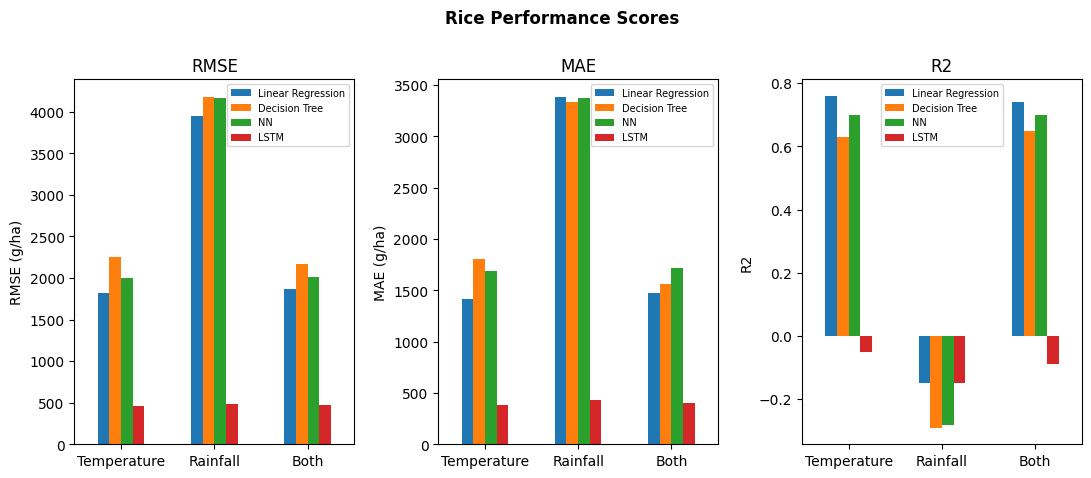

In [ ]:
# Plot Rice Performance
fig, ax = plt.subplots(1,3, figsize=(13,5), sharey=False)

eval_plot(lr_df=all_lr_rice, dt_df=all_dt_rice, nn_df=all_nn_rice, lstm_df=all_lstm_rice, metric='RMSE').plot(kind='bar', ax=ax[0])
ax[0].set_title('RMSE')
ax[0].set_xticks(ticks=[0,1,2], labels=['Temperature','Rainfall','Both'], rotation=360)
ax[0].set_ylabel('RMSE (g/ha)')
ax[0].legend(prop=dict(size=7))

eval_plot(lr_df=all_lr_rice, dt_df=all_dt_rice, nn_df=all_nn_rice, lstm_df=all_lstm_rice, metric='MAE').plot(kind='bar', ax=ax[1])
ax[1].set_title('MAE')
ax[1].set_xticks(ticks=[0,1,2], labels=['Temperature','Rainfall','Both'], rotation=360)
ax[1].set_ylabel('MAE (g/ha)')
ax[1].legend(prop=dict(size=7))

eval_plot(lr_df=all_lr_rice, dt_df=all_dt_rice, nn_df=all_nn_rice, lstm_df=all_lstm_rice, metric='R2').plot(kind='bar', ax=ax[2])
ax[2].set_title('R2')
ax[2].set_xticks(ticks=[0,1,2], labels=['Temperature','Rainfall','Both'], rotation=360)
ax[2].set_ylabel('R2')
ax[2].legend(prop=dict(size=7))

fig.subplots_adjust(wspace=0.3, top=0.84)
fig.suptitle('Rice Performance Scores', fontweight='bold')

## Maize Performance Plot

Text(0.5, 0.98, 'Maize Performance Scores')

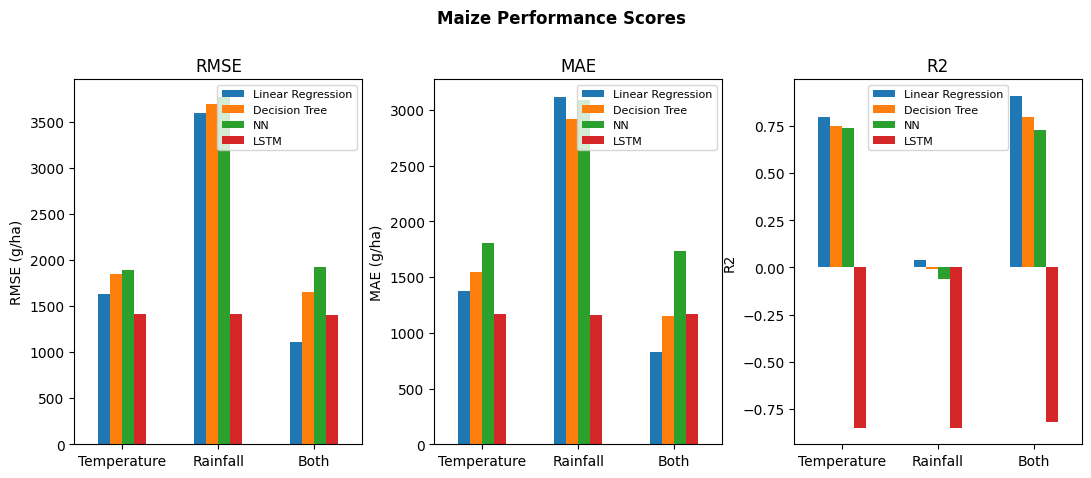

In [ ]:
# Plot Maize Performance
fig, ax = plt.subplots(1,3, figsize=(13,5), sharey=False)

eval_plot(lr_df=all_lr_maize, dt_df=all_dt_maize, nn_df=all_nn_maize, lstm_df=all_lstm_maize, metric='RMSE').plot(kind='bar', ax=ax[0])
ax[0].set_title('RMSE')
ax[0].set_xticks(ticks=[0,1,2], labels=['Temperature','Rainfall','Both'], rotation=360)
ax[0].set_ylabel('RMSE (g/ha)')
ax[0].legend(prop=dict(size=8))

eval_plot(lr_df=all_lr_maize, dt_df=all_dt_maize, nn_df=all_nn_maize, lstm_df=all_lstm_maize, metric='MAE').plot(kind='bar', ax=ax[1])
ax[1].set_title('MAE')
ax[1].set_xticks(ticks=[0,1,2], labels=['Temperature','Rainfall','Both'], rotation=360)
ax[1].set_ylabel('MAE (g/ha)')
ax[1].legend(prop=dict(size=8))

eval_plot(lr_df=all_lr_maize, dt_df=all_dt_maize, nn_df=all_nn_maize, lstm_df=all_lstm_maize, metric='R2').plot(kind='bar', ax=ax[2])
ax[2].set_title('R2')
ax[2].set_xticks(ticks=[0,1,2], labels=['Temperature','Rainfall','Both'], rotation=360)
ax[2].set_ylabel('R2')
ax[2].legend(prop=dict(size=8))

fig.subplots_adjust(wspace=0.25, top=0.84)
fig.suptitle('Maize Performance Scores', fontweight='bold')

## Wheat Performance Plot

Text(0.5, 0.98, 'Wheat Performance Scores')

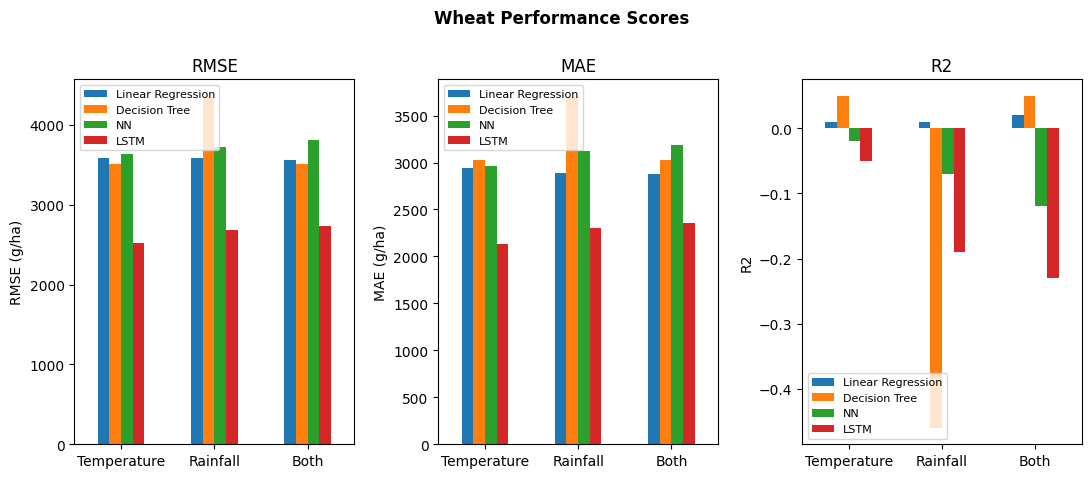

In [ ]:
# Plot wheat Performance
fig, ax = plt.subplots(1,3, figsize=(13,5), sharey=False)

eval_plot(lr_df=all_lr_wheat, dt_df=all_dt_wheat, nn_df=all_nn_wheat, lstm_df=all_lstm_wheat, metric='RMSE').plot(kind='bar', ax=ax[0])
ax[0].set_title('RMSE')
ax[0].set_xticks(ticks=[0,1,2], labels=['Temperature','Rainfall','Both'], rotation=360)
ax[0].set_ylabel('RMSE (g/ha)')
ax[0].legend(prop=dict(size=8))

eval_plot(lr_df=all_lr_wheat, dt_df=all_dt_wheat, nn_df=all_nn_wheat, lstm_df=all_lstm_wheat, metric='MAE').plot(kind='bar', ax=ax[1])
ax[1].set_title('MAE')
ax[1].set_xticks(ticks=[0,1,2], labels=['Temperature','Rainfall','Both'], rotation=360)
ax[1].set_ylabel('MAE (g/ha)')
ax[1].legend(prop=dict(size=8))

eval_plot(lr_df=all_lr_wheat, dt_df=all_dt_wheat, nn_df=all_nn_wheat, lstm_df=all_lstm_wheat, metric='R2').plot(kind='bar', ax=ax[2])
ax[2].set_title('R2')
ax[2].set_xticks(ticks=[0,1,2], labels=['Temperature','Rainfall','Both'], rotation=360)
ax[2].set_ylabel('R2')
ax[2].legend(prop=dict(size=8))

fig.subplots_adjust(wspace=0.3, top=0.84)
fig.suptitle('Wheat Performance Scores', fontweight='bold')

# Future Predictions (2023 -2033)

In [ ]:
def model_predictions(crop, best_model, features, scaler=4, model=3):
  """
  Generates crop yield predictions for the years 2023-2033.

  Parameters:
      crop (str): The name of the crop.
      best_model (str): The best predictive model ('linear_regression', 'lstm', 'nn', or 'dt').
      features (list): A list of features to be used for prediction.
      scaler (int, optional): The index of the scaler to be used. Defaults to 4.
      model (int, optional): The index of the model fit to be used. Defaults to 3.

  Returns:
      pandas.DataFrame: A DataFrame containing crop yield predictions for 2023-2033.
  """
  # future values from ARIMA
  future_vals=arima_10yr_forecasts[features]

  scaler = best_model[scaler] # Initialize model scaler
  scaled_features = scaler.fit_transform(future_vals) # Scale new features
  new_predictions = np.round(best_model[model].predict(scaled_features)) # Make predictions

  return pd.DataFrame(new_predictions, columns=[f'Future {crop} Yields'], index=[i for i in range(2023, 2033, 1)])

In [ ]:
# Create DataFrame with Future Predcitions
next_10_predictions = pd.concat([model_predictions(best_model=rice_lr_lst_scores, crop='Rice', features=['temp']),
                                 model_predictions(best_model=lr_rain_maize2, crop='Maize', features=['temp','rain']),
                                 model_predictions(best_model=wheat_dt_lst_scores, crop='Wheat', features=['temp'])], axis=1)

In [ ]:
# Display future prediction table
next_10_predictions

,Future Rice Yields,Future Maize Yields,Future Wheat Yields
2023,17476.0,16447.0,16244.0
2024,11658.0,4556.0,16191.0
2025,11393.0,7818.0,16191.0
2026,18005.0,13539.0,16244.0
2027,17212.0,15272.0,16244.0
2028,12187.0,6085.0,16191.0
2029,18005.0,16004.0,16244.0
2030,20650.0,17734.0,16244.0
2031,15889.0,13010.0,18590.0
2032,16683.0,12592.0,13970.0


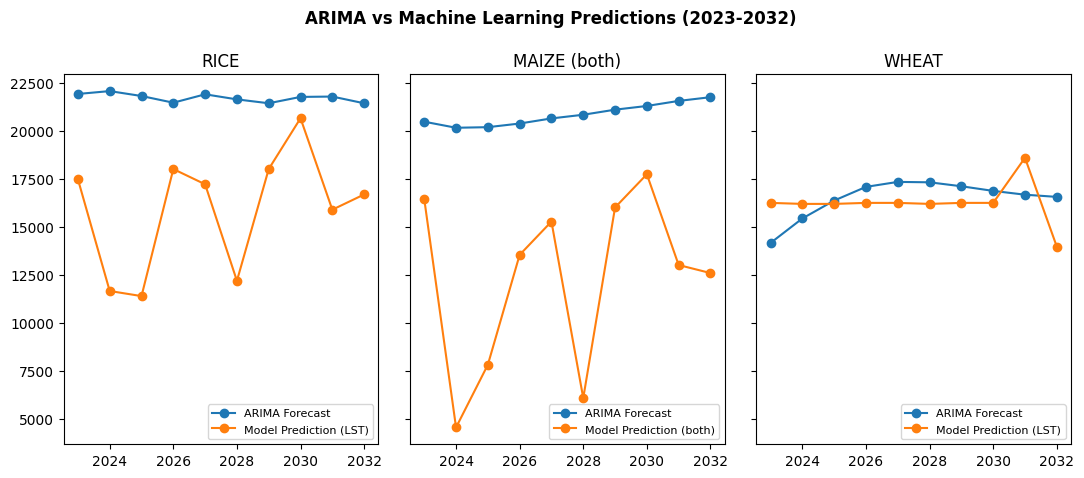

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(13,5), sharey=True)

# ARIMA vs ML Rice
ax[0].plot(arima_10yr_forecasts['rice'], label='ARIMA Forecast', marker='o')
ax[0].plot(next_10_predictions['Future Rice Yields'], label='Model Prediction (LST)', marker='o')
ax[0].legend(prop=dict(size=8), loc=4)
ax[0].set_title('RICE')

# ARIMA vs ML Maize
ax[1].plot(arima_10yr_forecasts['maize'], label='ARIMA Forecast', marker='o')
ax[1].plot(next_10_predictions['Future Maize Yields'], label='Model Prediction (both)', marker='o')
ax[1].legend(prop=dict(size=8), loc=4)
ax[1].set_title('MAIZE (both)')

# Arima vs ML Wheat
ax[2].plot(arima_10yr_forecasts['wheat'], label='ARIMA Forecast', marker='o')
ax[2].plot(next_10_predictions['Future Wheat Yields'], label='Model Prediction (LST)', marker='o')
ax[2].legend(prop=dict(size=8), loc=4)
ax[2].set_title('WHEAT')

# set plot title
plt.suptitle('ARIMA vs Machine Learning Predictions (2023-2032)', fontweight='bold')

# adjust plot
plt.subplots_adjust(wspace=0.1, top=0.85)